# Reservoir Computing based on **NVAR** (*nonlinear vector autoregression*)

*Reference:* "Next generation reservoir computing", Gauthier *et al.* (2021), https://www.nature.com/articles/s41467-021-25801-2

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

import time as time
import pandas as pd
from IPython.display import Image

### Implementation using *ReservoirPy*, a Python library (based on *NumPy* and *SciPy*) that allows to implement Reservoir Computing architectures

https://reservoirpy.readthedocs.io/en/latest/index.html

https://github.com/reservoirpy/reservoirpy

- As for the reservoir node of the RC architecture, we use the ReservoirPy's **NVAR** node, a Nonlinear Vector AutoRegressive machine implemented as described in *Reference*.

***

The state $\mathbb{O}_{total}$ of the NVAR first contains a serie of linear features $\mathbb{O}_{lin}$ made of input data concatenated with delayed inputs:

$$
\mathbb{O}_{lin}[t] = \mathbf{X}[t] \oplus \mathbf{X}[t - s] \oplus \mathbf{X}[t - 2s] \oplus \dots \oplus \mathbf{X}[t - (k-1)s]
$$

where $\mathbf{X}[t]$ are the inputs at time $t$, $k$ is the delay and $s$ is the strides (only one input every $s$ inputs within the delayed inputs is used). The operator $\oplus$ denotes the concatenation.

In addition to these linear features, nonlinear representations $\mathbb{O}_{nonlin}^n$ of the inputs are contructed using all unique monomials of order $n$ of these inputs:

$$
\mathbb{O}_{nonlin}^n[t] = \mathbb{O}_{lin}[t] \otimes \mathbb{O}_{lin}[t] \overbrace{\otimes \dots \otimes}^{n-1~\mathrm{times}} \mathbb{O}_{lin}[t]
$$

where $\otimes$ is the operator denoting an outer product followed by the selection of all unique monomials generated by this outer product. Under the hood, this product is computed by ReservoirPy by finding all unique combinations of input features and multiplying each combination of terms.

Finally, all representations are gathered to form the final feature vector $\mathbb{O}_{total}$:

$$
\mathbb{O}_{total} = \mathbb{O}_{lin}[t] \oplus \mathbb{O}_{nonlin}^n[t]
$$

***

- As for the offline readout node of the RC architecture, we use the ReservoirPy's **Ridge** node, a single layer of neurons whose readout weights are learned through Tikhonov linear regression using $\mathbb{O}_{total}$.

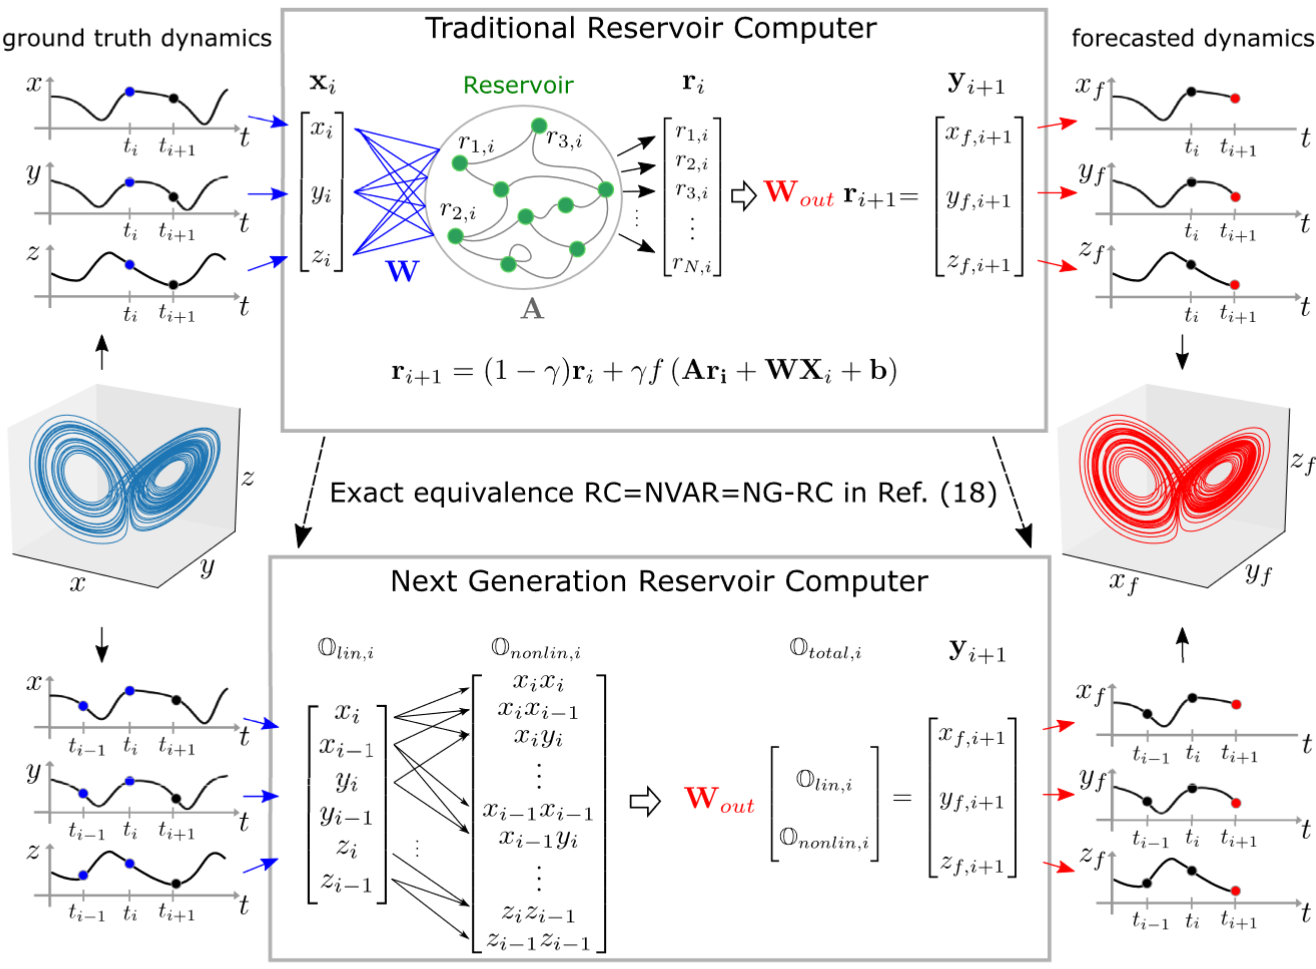

In [2]:
Image("Fig1.png", width=750)

**Fig. 1 A traditional RC is implicit in an NG-RC.** *(top)* A traditional RC processes time-series data associated with a strange attractor *(blue, middle left)*
using an artiﬁcial recurrent neural network. The forecasted strange attractor *(red, middle right)* is a linear weight of the reservoir states. *(bottom)* The NG-RC performs a forecast using a linear weight of time-delay states (two times shown here) of the time series data and nonlinear functionals of this data (quadratic functional shown here).

Figure and legend from *Reference*.

In [3]:
def Plot1D(X, titl1, titl2, titl3, start, pt_number, lw):
    xs, ys, zs = X[:,0], X[:,1], X[:,2]

    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15, 15))

    ax1.plot(xs[start:start+pt_number], lw=lw)
    ax1.set_title(titl1)
    ax1.set_xlabel("time")
    ax1.set_ylabel("X Axis")

    ax2.plot(ys[start:start+pt_number], lw=lw)
    ax2.set_title(titl2)
    ax2.set_xlabel("time")
    ax2.set_ylabel("Y Axis")

    ax3.plot(zs[start:start+pt_number], lw=lw)
    ax3.set_title(titl3)
    ax3.set_xlabel("time")
    ax3.set_ylabel("Z axis")

    plt.show()

In [4]:
def Plot2D(X, titl1, titl2, titl3, start, pt_number, lw, N, color):
    xs, ys, zs = X[:,0], X[:,1], X[:,2]
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15, 5))

    ax1.set_title(titl1)
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")

    ax2.set_title(titl2)
    ax2.set_xlabel("X Axis")
    ax2.set_ylabel("Z Axis")

    ax3.set_title(titl3)
    ax3.set_xlabel("Y Axis")
    ax3.set_ylabel("Z Axis")

    if color:
        cmap = plt.cm.magma#plt.cm.winter
        for i in range(N-1):
            ax1.plot(X[i:i+2, 0], X[i:i+2, 1], color=cmap(255*i//N), lw=lw)
            ax2.plot(X[i:i+2, 0], X[i:i+2, 2], color=cmap(255*i//N), lw=lw)
            ax3.plot(X[i:i+2, 1], X[i:i+2, 2], color=cmap(255*i//N), lw=lw)
    else:
        ax1.plot(xs[start:start+pt_number], ys[start:start+pt_number], lw=lw)
        ax2.plot(xs[start:start+pt_number], zs[start:start+pt_number], lw=lw)
        ax3.plot(ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)

    plt.show()

In [5]:
def plot3D(X, title, pt_number, N, color, start, lw):
    xs, ys, zs = X[:,0], X[:,1], X[:,2]
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.grid(False)

    if color:
        cmap = plt.cm.magma#plt.cm.winter
        for i in range(N-1):
            ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=cmap(255*i//N), lw=1.0)
    else:
        ax.plot(xs[start:start+pt_number], ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)

    plt.show()

## 0. Generate Lorenz attractor timeseries

$$
\begin{split}
\dot{x} &= \sigma(y-x)\\
\dot{y} &= x(\rho-z)-y\\
\dot{z} &= xy - \beta z
\end{split}
$$

In [6]:
def lorenz_inside(x, y, z, sigma, rho, beta):
    """
    Given:
    x, y, z: a point of interest in three dimensional space
    sigma, rho, beta: parameters defining the lorenz attractor
    Returns:
    x_dot, y_dot, z_dot: values of the lorenz attractor's partial
    derivatives at the point x, y, z
    """
    x_dot = sigma*(y - x)
    y_dot = rho*x - y - x*z
    z_dot = x*y - beta*z
    return x_dot, y_dot, z_dot

def lorenz_generation(steps, rho, sigma, beta, x0, h, method, select_f):
    t1 = time.time() #times the computation

    if select_f == 1:
        # Need one more for the initial values
        xs = np.empty(steps + 1)
        ys = np.empty(steps + 1)
        zs = np.empty(steps + 1)
        # Set initial values
        xs[0], ys[0], zs[0] = x0[0], x0[1], x0[2]
        # Step through "time", calculating the partial derivatives at the current point
        # and using them to estimate the next point
        for i in range(steps):
            x_dot, y_dot, z_dot = lorenz_inside(xs[i], ys[i], zs[i], sigma, rho, beta)
            xs[i + 1] = xs[i] + (x_dot * h)
            ys[i + 1] = ys[i] + (y_dot * h)
            zs[i + 1] = zs[i] + (z_dot * h)
        X = np.array([xs, ys, zs])
        t2 = time.time()
        return X.T, xs, ys, zs
        print ('computation took ',t2-t1,' seconds.')

    if (select_f == 2) or (h > 0.01):
        X = lorenz(steps, rho=rho, sigma=sigma, beta=beta, x0=x0, h=h, method = method)
        xs, ys, zs = X[:,0], X[:,1], X[:,2]
        t2 = time.time()
        return X, xs, ys, zs
        #print ('computation took ',t2-t1,' seconds.')

In [7]:
dt         = 0.001 # time step duration (in time unit)
train_time = 10.   # training time (in time unit)
test_time  = 185.  # testing time (idem)
warm_time  = 5.    # warmup time (idem): should always be > k * s

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [8]:
# Lorenz parameters
n_timesteps = train_steps + test_steps + warm_steps
rho    =  28
sigma  = 10
beta   = 8/3
x0     = [-8, 8, 27]
method = 'LSODA' # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

X, xs, ys, zs = lorenz_generation(n_timesteps, rho, sigma, beta, x0=x0, h=dt, method=method, select_f=2)

lorenz_df = pd.DataFrame(X, columns=['x', 'y', 'z'])
lorenz_df

,x,y,z
0,-8.000000,8.000000,27.000000
1,-7.842761,7.982643,26.866764
2,-7.687838,7.964251,26.735828
3,-7.532189,7.946183,26.604171
4,-7.378253,7.927423,26.474201
...,...,...,...
199995,0.587622,-0.307619,20.053772
199996,0.578739,-0.302669,20.000188
199997,0.569994,-0.297763,19.946753
199998,0.561385,-0.292901,19.893465


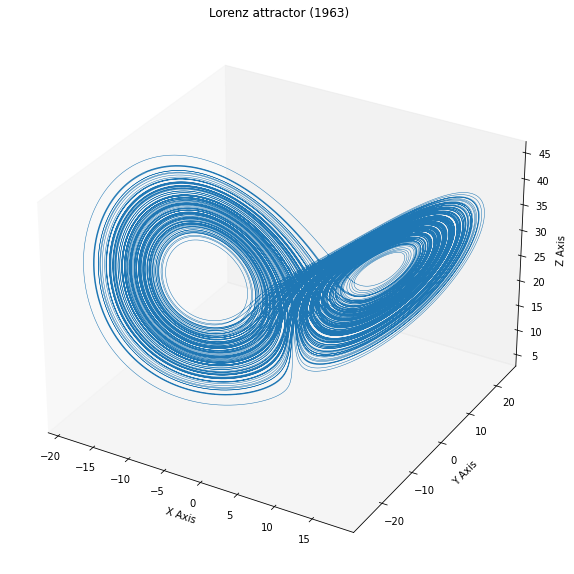

In [9]:
plot3D(X, title = "Lorenz attractor (1963)", start=0, pt_number = n_timesteps, N = n_timesteps, color=False, lw = 0.5)

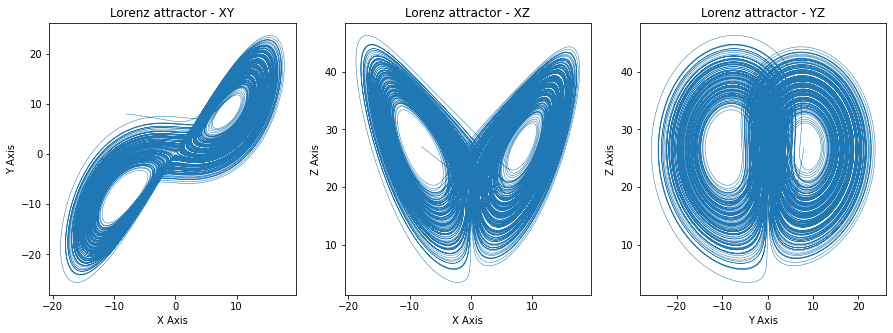

In [10]:
Plot2D(X, "Lorenz attractor - XY", "Lorenz attractor - XZ", "Lorenz attractor - YZ", start=0, pt_number=n_timesteps, lw=0.5, N = n_timesteps, color=False)

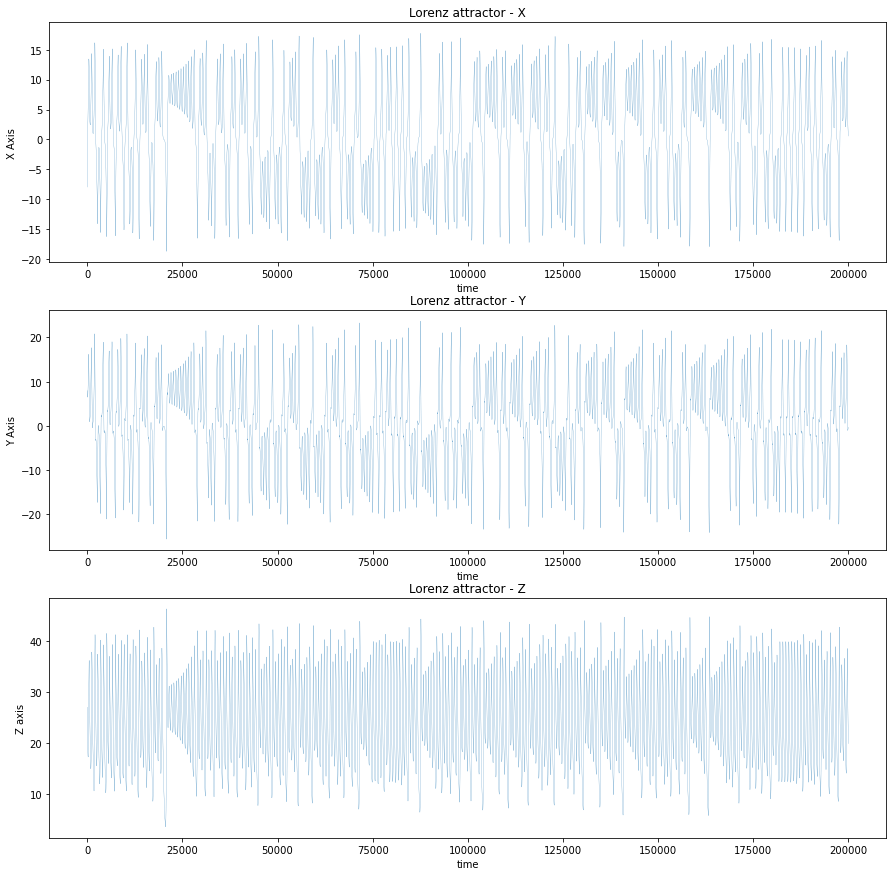

In [11]:
Plot1D(np.array([xs, ys, zs]).T, "Lorenz attractor - X", "Lorenz attractor - Y", "Lorenz attractor - Z", start=0, pt_number=n_timesteps, lw=0.2)

## 1. NVAR for Lorenz attractor forecasting

Let's define an NVAR with:

- delay $k=2$
- strides $s=1$
- order $n=2$

Therefore, the final feature vector $\mathbb{O}_{total}$ will be the following:

$$
\mathbb{O}_{total}[t] = \mathbb{O}_{lin}[t] \oplus \mathbb{O}_{nonlin}[t]
$$

where

$$
\begin{align}
\mathbb{O}_{lin}[t] &=
    \begin{bmatrix}
         x_t\\y_t\\z_t\\x_{t-1}\\y_{t-1}\\z_{t-1}
    \end{bmatrix}
&
\mathbb{O}_{nonlin}[t] &=
    \begin{bmatrix}
       x_t^2\\x_t y_t\\x_t z_t\\x_t x_{t-1}\\x_t y_{t-1}\\x_t
       z_{t-1}\\y_t^2\\y_t z_t\\y_t x_{t-1}\\y_t y_{t-1}\\y_t z_{t-1}\\z_t^2\\z_t x_{t-1}\\z_t y_{t-1}\\z_t
       z_{t-1}\\x_{t-1}^2\\x_{t-1} y_{t-1}\\x_{t-1} z_{t-1}\\y_{t-1}^2\\y_{t-1} z_{t-1}\\z_{t-1}^2
    \end{bmatrix}
\end{align}
$$

Then, let's connect the NVAR to a readout layer with offline learning using Tikhonov linear regression (Ridge regularization).

In [12]:
nvar = NVAR(delay=2, order=2, strides=25)
readout = Ridge(output_dim=3, ridge=2.5e-6)

model = nvar >> readout

Now, let's train the model to perform one-step-ahead prediction, i.e., to infer the value of $\mathbf{X}[t+1]$ knowing the value of $\mathbf{X}[t]$.

In [13]:
X_train  = X[:train_steps+warm_steps-1]
Y_train  = X[1:train_steps+warm_steps]

model = model.fit(X_train, Y_train, warmup=warm_steps)

Running Model-0: 14999it [00:01, 9736.44it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Fitting node Ridge-0...


Let's visualize the coefficients learned by the model:

In [14]:
lin = ["$x_t$", "$y_t$", "$z_t$", "$x_{t-1}$", "$y_{t-1}$", "$z_{t-1}$"]

nonlin = []
for idx in nvar._monomial_idx:
    idx = idx.astype(int)
    if idx[0] == idx[1]:
        c = lin[idx[0]][:-1] + "^2$"
    else:
        c = " ".join((lin[idx[0]][:-1], lin[idx[1]][1:]))

    nonlin.append(c)

coefs = ["$c$"] + lin + nonlin

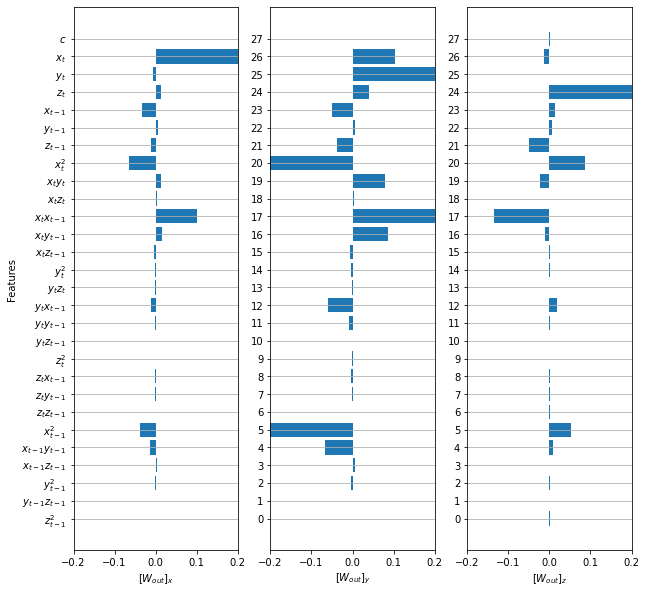

In [15]:
fig = plt.figure(figsize=(10, 10))

Wout = np.r_[readout.bias, readout.Wout]
x_Wout, y_Wout, z_Wout = Wout[:, 0], Wout[:, 1], Wout[:, 2]

ax = fig.add_subplot(131)
ax.set_xlim(-0.2, 0.2)
ax.grid(axis="y")
ax.set_xlabel("$[W_{out}]_x$")
ax.set_ylabel("Features")
ax.set_yticks(np.arange(len(coefs)))
ax.set_yticklabels(coefs[::-1])
ax.barh(np.arange(x_Wout.size), x_Wout.ravel()[::-1])

ax1 = fig.add_subplot(132)
ax1.set_xlim(-0.2, 0.2)
ax1.grid(axis="y")
ax1.set_yticks(np.arange(len(coefs)))
ax1.set_xlabel("$[W_{out}]_y$")
ax1.barh(np.arange(y_Wout.size), y_Wout.ravel()[::-1])

ax2 = fig.add_subplot(133)
ax2.set_xlim(-0.2, 0.2)
ax2.grid(axis="y")
ax2.set_yticks(np.arange(len(coefs)))
ax2.set_xlabel("$[W_{out}]_z$")
ax2.barh(np.arange(z_Wout.size), z_Wout.ravel()[::-1])

plt.show()

Now, let's perform one-step-ahead prediction:

In [16]:
nvar.run(X[train_steps:warm_steps+train_steps]) # warming phase

u = X[warm_steps+train_steps]
Y_pred = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    Y_pred[i, :] = model(u)
    u = Y_pred[i, :]

Running NVAR-0: 100%|██████████| 5000/5000 [00:00<00:00, 18839.71it/s]


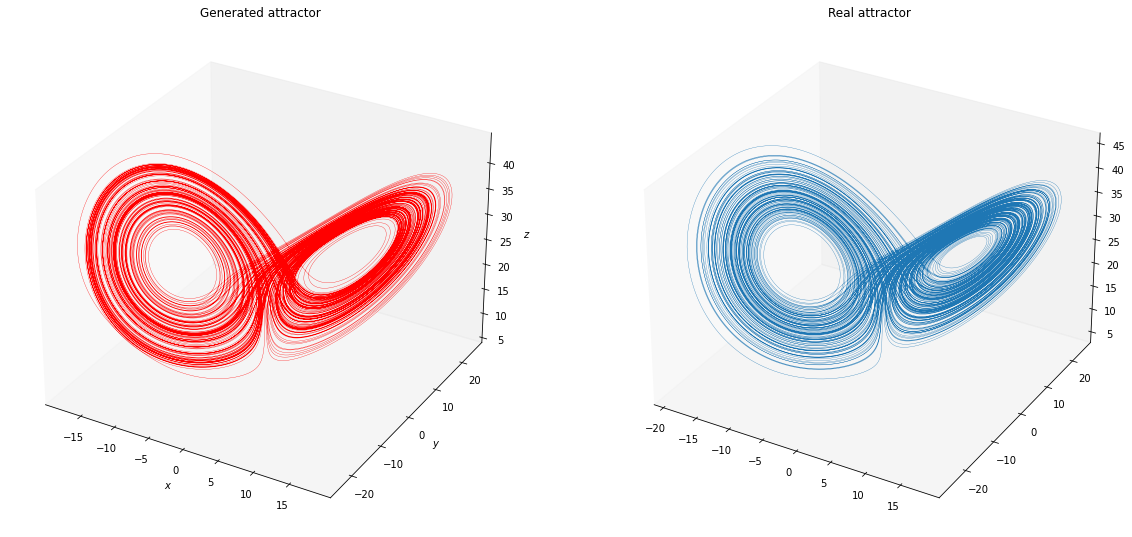

In [17]:
Y_test = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(20, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.set_title("Generated attractor")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.grid(False)
ax.plot(Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2], color='red', lw=.3)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real attractor")
ax2.grid(False)
ax2.plot(Y_test[:, 0], Y_test[:, 1], Y_test[:, 2], lw=.3)

plt.show()

## 2. Reconstruction of $z$ coordinate from $x$ coordinate

Let's try to predict coordinate $z[t]$ at time $t$ given the coordinate $x[t-1]$ at time $t-1$.

In [18]:
nvar    = NVAR(delay=4, order=2, strides=25)
readout = Ridge(output_dim=1, ridge=0.05)

model = nvar >> readout

In [19]:
X_train = X[:train_steps+warm_steps-1, 0].reshape(-1,1) # x coordinate
Y_train = X[1:train_steps+warm_steps, 2].reshape(-1,1)  # z coordinate

model = model.fit(X_train, Y_train, warmup=warm_steps)

Running Model-1: 14999it [00:01, 8844.43it/s]?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Fitting node Ridge-1...


In [20]:
nvar.run(X[train_steps:warm_steps+train_steps, 0].reshape(-1,1)) # warming phase

X_test = X[warm_steps+train_steps:-1, 0].reshape(-1,1)
Y_pred = model.run(X_test)

Running NVAR-1: 100%|██████████| 5000/5000 [00:00<00:00, 16255.00it/s]
Running Model-1: 184999it [00:20, 9059.66it/s]        


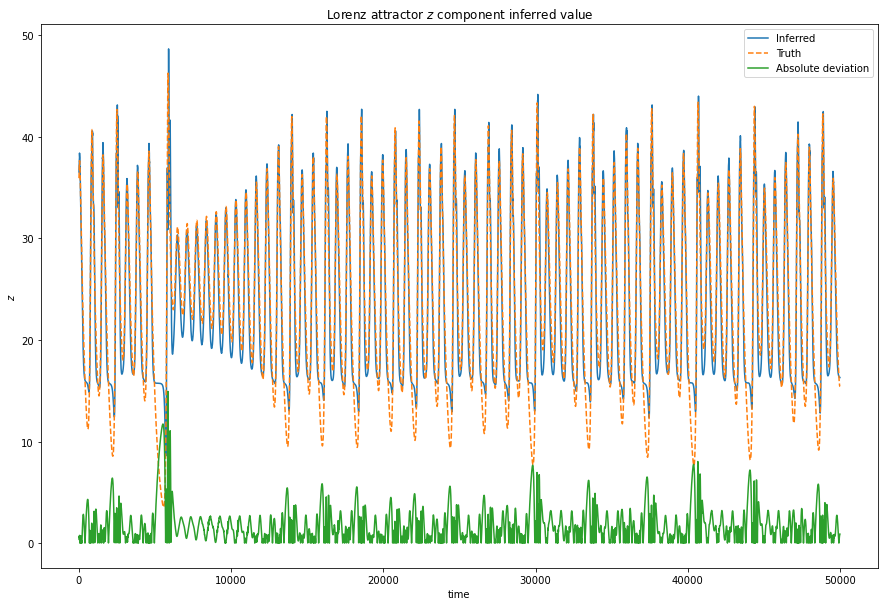

In [21]:
Y_test = X[warm_steps+train_steps+1:, 2]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Y_pred[:50000], label="Inferred")
ax.plot(Y_test[:50000], label="Truth", linestyle="--")
ax.plot(abs(Y_pred[:,0][:50000] - Y_test[:50000]), label="Absolute deviation")
ax.set_ylabel("$z$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $z$ component inferred value")
#ax.set_xticks(np.linspace(0, 900, 5))
#ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()

## 3. Reconstruction of $z$ coordinate from $y$ coordinate

Let's try to predict coordinate $z[t]$ at time $t$ given the coordinate $y[t-1]$ at time $t -1$.

In [22]:
nvar    = NVAR(delay=4, order=2, strides=25)
readout = Ridge(output_dim=1, ridge=0.05)

model = nvar >> readout

In [23]:
X_train = X[:train_steps+warm_steps-1, 1].reshape(-1,1) # y coordinate
Y_train = X[1:train_steps+warm_steps, 2].reshape(-1,1)  # z coordinate

model = model.fit(X_train, Y_train, warmup=warm_steps)

Running Model-2: 14999it [00:01, 9522.31it/s]?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Fitting node Ridge-2...


In [24]:
nvar.run(X[train_steps:warm_steps+train_steps, 1].reshape(-1,1)) # warming phase

X_test = X[warm_steps+train_steps:-1, 1].reshape(-1,1)
Y_pred = model.run(X_test)

Running NVAR-2: 100%|██████████| 5000/5000 [00:00<00:00, 18372.43it/s]
Running Model-2: 184999it [00:18, 10175.82it/s]       


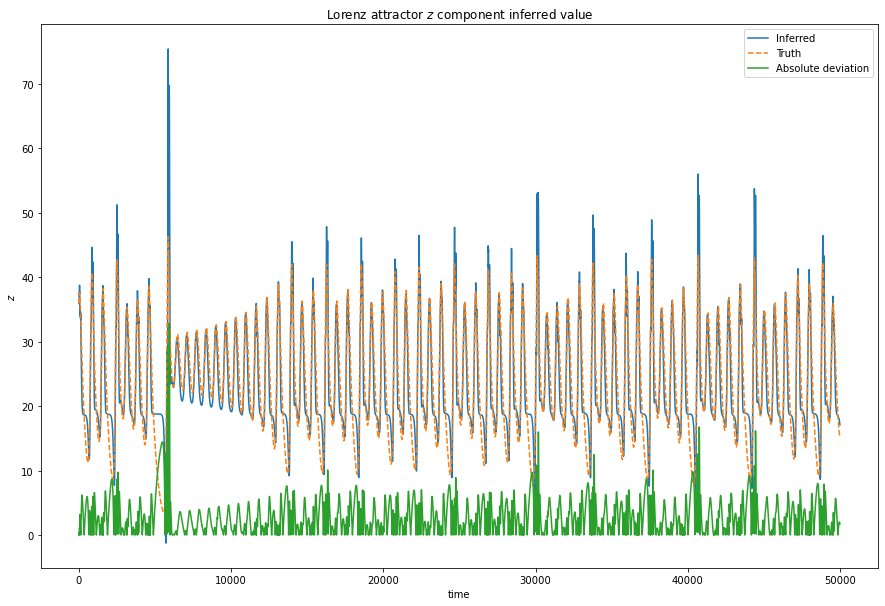

In [25]:
Y_test = X[warm_steps+train_steps+1:, 2]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Y_pred[:50000], label="Inferred")
ax.plot(Y_test[:50000], label="Truth", linestyle="--")
ax.plot(abs(Y_pred[:,0][:50000] - Y_test[:50000]), label="Absolute deviation")
ax.set_ylabel("$z$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $z$ component inferred value")
#ax.set_xticks(np.linspace(0, 900, 5))
#ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()

## 4. Reconstruction of $z$ coordinate from $(x, y)$ coordinates

Let's try to predict coordinate $z[t]$ at time $t$ given the two other coordinates $(x[t-1], y[t-1])$ at time $t -1$.

In [26]:
nvar    = NVAR(delay=4, order=2, strides=125)
readout = Ridge(output_dim=1, ridge=0.05)

model = nvar >> readout

In [27]:
X_train = X[:train_steps+warm_steps-1, :2]              # (x,y) coordinates
Y_train = X[1:train_steps+warm_steps, 2].reshape(-1,1)  # z coordinate

model = model.fit(X_train, Y_train, warmup=warm_steps)

Running Model-3: 14999it [00:01, 9319.16it/s]?, ?it/s]
Running Model-3: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Fitting node Ridge-3...


In [28]:
nvar.run(X[train_steps:warm_steps+train_steps, :2]) # warming phase

X_test = X[warm_steps+train_steps:-1, :2]
Y_pred = model.run(X_test)

Running NVAR-3: 100%|██████████| 5000/5000 [00:00<00:00, 18180.54it/s]
Running Model-3: 184999it [00:18, 9976.84it/s]        


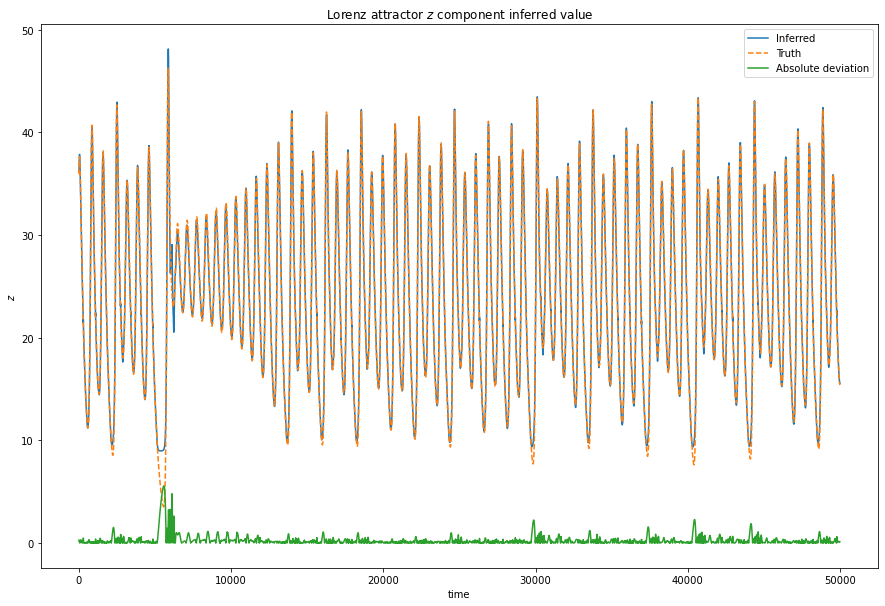

In [29]:
Y_test = X[warm_steps+train_steps+1:, 2]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Y_pred[:50000], label="Inferred")
ax.plot(Y_test[:50000], label="Truth", linestyle="--")
ax.plot(abs(Y_pred[:,0][:50000] - Y_test[:50000]), label="Absolute deviation")
ax.set_ylabel("$z$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $z$ component inferred value")
#ax.set_xticks(np.linspace(0, 900, 5))
#ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()

## 5. Reconstruction of $(x, y)$ coordinates from $z$ coordinate
Let's try to predict coordinates $(x[t], y[t])$ at time $t$ given the coordinate $z[t-1]$ at time $t -1$.

In [30]:
nvar    = NVAR(delay=4, order=2, strides=125)
readout = Ridge(output_dim=2, ridge=0.05)

model = nvar >> readout

In [31]:
X_train = X[:train_steps+warm_steps-1, 2].reshape(-1,1) # z coordinate
Y_train = X[1:train_steps+warm_steps, :2]               # (x,y) coordinates

model = model.fit(X_train, Y_train, warmup=warm_steps)

Running Model-4: 14999it [00:02, 7445.78it/s]?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Fitting node Ridge-4...


In [32]:
nvar.run(X[train_steps:warm_steps+train_steps, 2].reshape(-1,1)) # warming phase

X_test = X[warm_steps+train_steps:-1, 2].reshape(-1,1)
Y_pred = model.run(X_test)

Running NVAR-4: 100%|██████████| 5000/5000 [00:00<00:00, 14471.27it/s]
Running Model-4: 184999it [00:20, 9208.49it/s]        


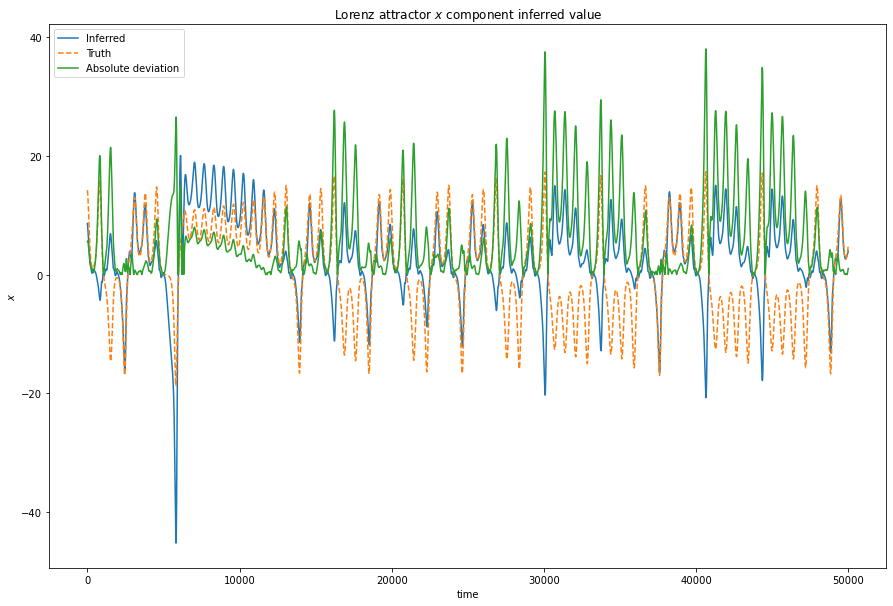

In [33]:
Y_test = X[warm_steps+train_steps+1:, 0]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Y_pred[:50000,0], label="Inferred")
ax.plot(Y_test[:50000], label="Truth", linestyle="--")
ax.plot(abs(Y_pred[:,0][:50000] - Y_test[:50000]), label="Absolute deviation")
ax.set_ylabel("$x$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $x$ component inferred value")
#ax.set_xticks(np.linspace(0, 900, 5))
#ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()

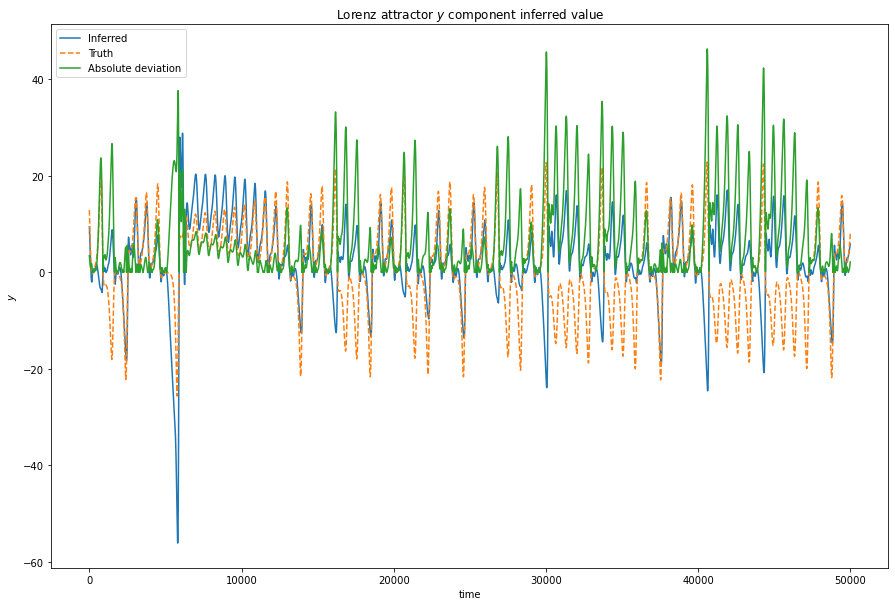

In [34]:
Y_test = X[warm_steps+train_steps+1:, 1]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Y_pred[:50000,1], label="Inferred")
ax.plot(Y_test[:50000], label="Truth", linestyle="--")
ax.plot(abs(Y_pred[:,1][:50000] - Y_test[:50000]), label="Absolute deviation")
ax.set_ylabel("$y$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $y$ component inferred value")
#ax.set_xticks(np.linspace(0, 900, 5))
#ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()

## 6. Reconstruction of $(y, z)$ coordinates from $x$ coordinate

Let's try to predict coordinates $(y[t], z[t])$ at time $t$ given the coordinate $x[t-1]$ at time $t -1$.

In [35]:
nvar    = NVAR(delay=4, order=2, strides=125)
readout = Ridge(output_dim=2, ridge=0.05)

model = nvar >> readout

In [36]:
X_train = X[:train_steps+warm_steps-1, 0].reshape(-1,1) # x coordinate
Y_train = X[1:train_steps+warm_steps, 1:]               # (y,z) coordinates

model = model.fit(X_train, Y_train, warmup=warm_steps)

Running Model-5: 14999it [00:01, 8307.54it/s]?, ?it/s]
Running Model-5: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Fitting node Ridge-5...


In [37]:
nvar.run(X[train_steps:warm_steps+train_steps, 0].reshape(-1,1)) # warming phase

X_test = X[warm_steps+train_steps:-1, 0].reshape(-1,1)
Y_pred = model.run(X_test)

Running NVAR-5: 100%|██████████| 5000/5000 [00:00<00:00, 13613.62it/s]
Running Model-5: 184999it [00:18, 10026.98it/s]       


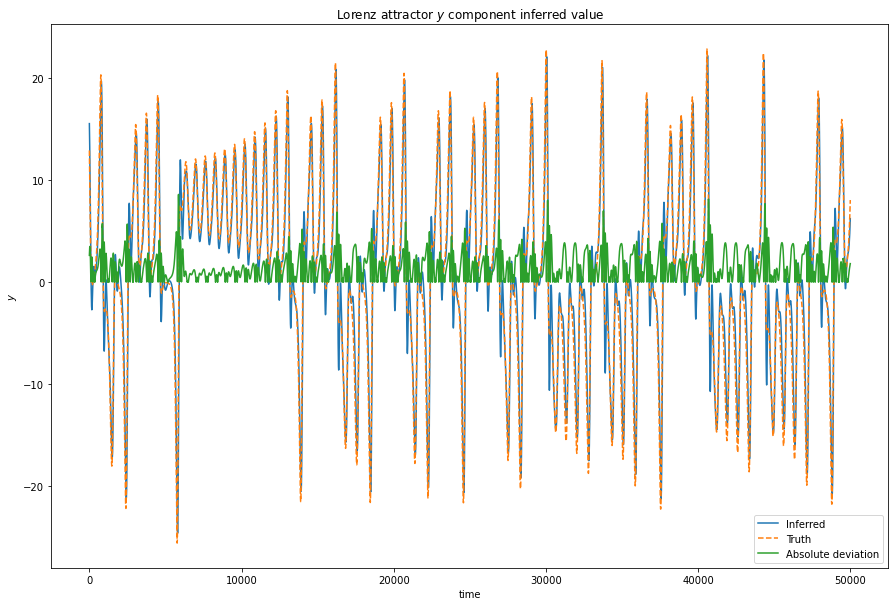

In [38]:
Y_test = X[warm_steps+train_steps+1:, 1]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Y_pred[:50000,0], label="Inferred")
ax.plot(Y_test[:50000], label="Truth", linestyle="--")
ax.plot(abs(Y_pred[:,0][:50000] - Y_test[:50000]), label="Absolute deviation")
ax.set_ylabel("$y$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $y$ component inferred value")
#ax.set_xticks(np.linspace(0, 900, 5))
#ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()

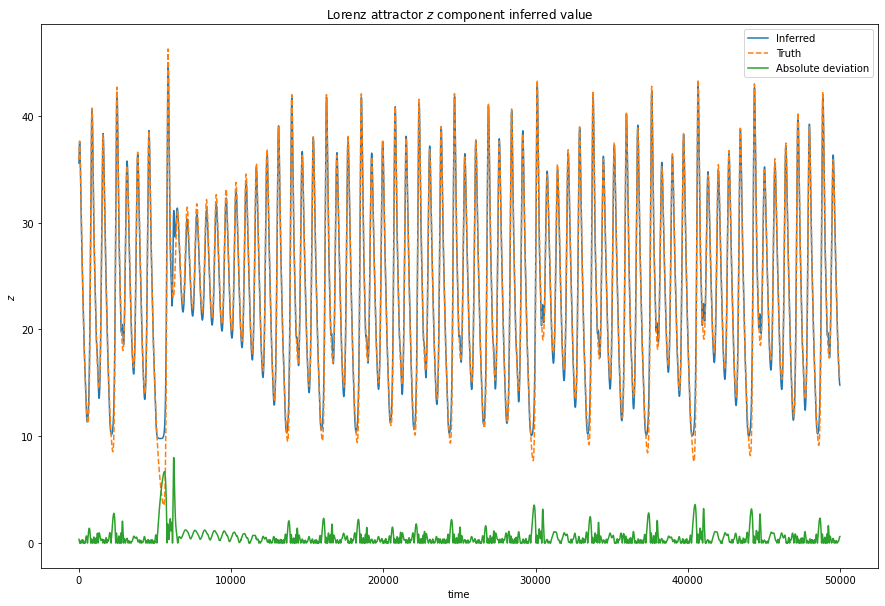

In [39]:
Y_test = X[warm_steps+train_steps+1:, 2]

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(Y_pred[:50000,1], label="Inferred")
ax.plot(Y_test[:50000], label="Truth", linestyle="--")
ax.plot(abs(Y_pred[:,1][:50000] - Y_test[:50000]), label="Absolute deviation")
ax.set_ylabel("$z$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $z$ component inferred value")
#ax.set_xticks(np.linspace(0, 900, 5))
#ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()

## 7. Robustness to noise

In [40]:
import numpy.random as npr
X_noisy = X + npr.normal(loc=0.0, scale=.1, size=X.shape)
lorenz_noisy_df = pd.DataFrame(X_noisy, columns=['x', 'y', 'z'])
lorenz_noisy_df

,x,y,z
0,-8.044568,8.005163,27.021958
1,-7.953021,7.959684,26.802126
2,-7.612010,8.006015,26.708173
3,-7.396956,7.944775,26.541215
4,-7.396851,7.884962,26.382039
...,...,...,...
199995,0.618672,-0.239514,19.961949
199996,0.463522,-0.414325,19.928728
199997,0.649794,-0.246454,19.959362
199998,0.428968,-0.428721,19.833756


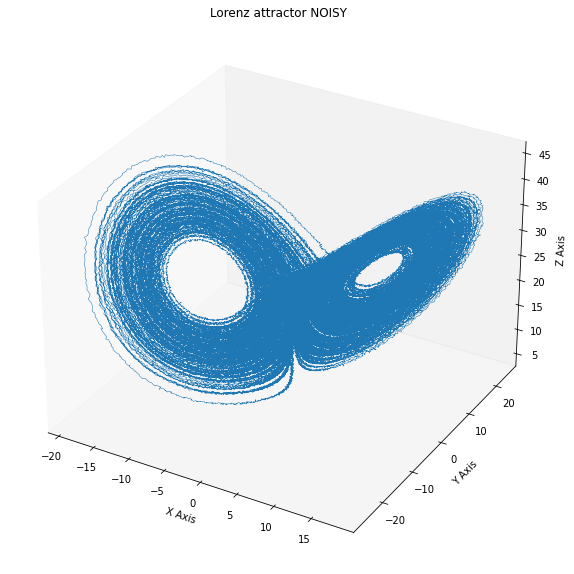

In [41]:
plot3D(X_noisy, title = "Lorenz attractor NOISY", start=0, pt_number = n_timesteps, N = n_timesteps, color=False, lw = 0.5)

In [42]:
nvar = NVAR(delay=4, order=2, strides=5)
readout = Ridge(output_dim=3, ridge=0.05)

model = nvar >> readout

In [43]:
X_train  = X_noisy[:train_steps+warm_steps-1]
Y_train  = X_noisy[1:train_steps+warm_steps]

model = model.fit(X_train, Y_train, warmup=warm_steps)

Running Model-6: 14999it [00:01, 9597.69it/s]?, ?it/s]
Running Model-6: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Fitting node Ridge-6...


In [44]:
nvar.run(X_noisy[train_steps:warm_steps+train_steps]) # warming phase

u = X_noisy[warm_steps+train_steps]
Y_pred = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    Y_pred[i, :] = model(u)
    u = Y_pred[i, :]

Running NVAR-6: 100%|██████████| 5000/5000 [00:00<00:00, 16256.87it/s]


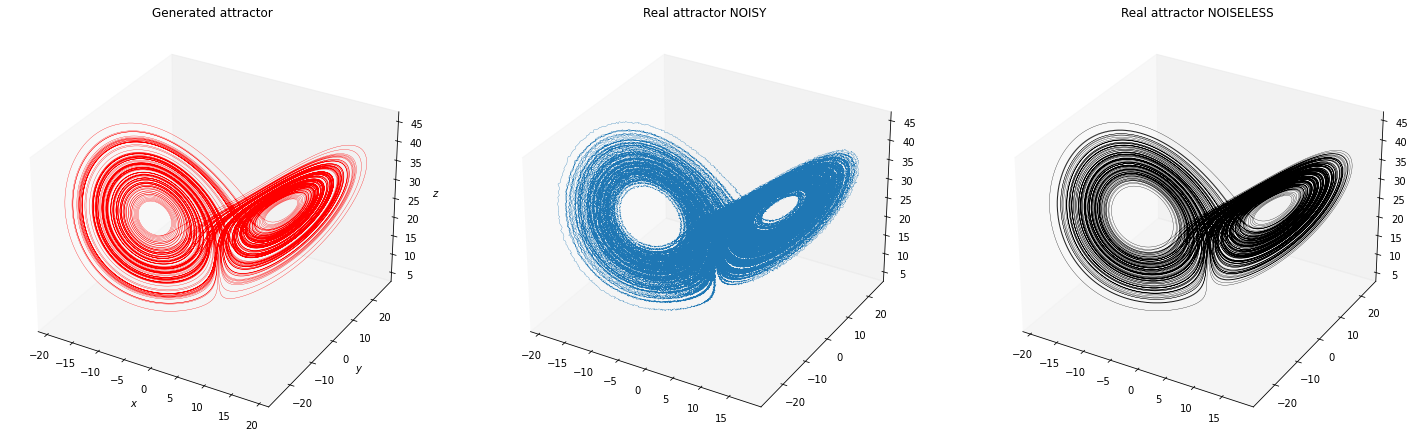

In [45]:
Y_test = X_noisy[warm_steps+train_steps:]

fig = plt.figure(figsize=(25, 15))
ax  = fig.add_subplot(131, projection='3d')
ax.set_title("Generated attractor")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.grid(False)
ax.plot(Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2], color='red', lw=.3)

ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title("Real attractor NOISY")
ax2.grid(False)
ax2.plot(Y_test[:, 0], Y_test[:, 1], Y_test[:, 2], lw=.3)

ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title("Real attractor NOISELESS")
ax3.grid(False)
ax3.plot(X[warm_steps+train_steps:][:, 0], X[warm_steps+train_steps:][:, 1], X[warm_steps+train_steps:][:, 2], color='black', lw=.3)

plt.show()

End of file.